# AGRICULTURE - MODEL 1 - B
## Simple lagged Decision tree per year, no lat/long info

The goal hear is to have the simplest decision tree using 1-year lag and all the variables constructed, in order to select the most pertinent subset

*I ignore the spatial aspect here to construct an example, will add soon*

## Initialise
### Imports

In [1]:
import time
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Constants

In [2]:
FINAL_DATAFILE = "12_20_dataset_reduced.csv"
TARGET = "C_perc"  # A for Agriculture, C for manufaCtoring 
# which columns to drop, e.g. here the other target variables, time, nuts name, and index
DROP_COLS = ["A_perc",  # other variables in the same moment
             "NUTS_ID", "CNTR_CODE",  # spatial coords
             "longitude", "latitude",  # gis coords
             'MOUNT_TYPE', 'COAST_TYPE',  # non-climate variables
            ]  # superfluous indices
LAG_COLS = ["n_sma", "hwi_sum"]  # which cols to lag
MIN_YEAR = 2003  # for ex. to eliminated lagged NA
MAX_YEAR = 2018

### Load dataset

In [3]:
in_df = pd.read_csv(FINAL_DATAFILE, index_col=0)
in_df

NUTS_ID  year  spi_01_max  spi_03_max  spi_06_max  SPI_12_max  n_sma  \
0       AT111  2002      1.5995      1.4325      1.1380      0.3155    7.0   
1       AT111  2003      0.6405      0.6860      1.6705      0.6805    1.0   
2       AT111  2004      1.5920      1.4985      1.6150      0.3535    0.0   
3       AT111  2005      1.4460      1.3905      1.2395      0.6435    0.0   
4       AT111  2006      1.6185      1.2760      1.2195      1.6320    3.0   
...       ...   ...         ...         ...         ...         ...    ...   
24630   SK042  2014      1.3330      1.3305      1.1010      0.8715    2.0   
24631   SK042  2015      1.8725      0.4610      0.6085      0.7780    6.0   
24632   SK042  2016      1.9520      1.4030      0.9855      0.6285    0.0   
24633   SK042  2017      1.6255      1.3440      1.1425      0.7405    0.0   
24634   SK042  2018      1.0485      1.3115      2.0210      1.1535    2.0   

         hwi_sum  tmax_mean  lfi_count_y  ...  COAST_TYPE  longitude  \
0      17.450511  14.163750          0.0  ...         3.0  16.476818   
1      10.337299  14.362667          0.0  ...         3.0  16.476818   
2       5.598158  13.233500          0.0  ...         3.0  16.476818   
3       1.529521  12.495500          0.0  ...         3.0  16.476818   
4       9.340811  13.789333          0.0  ...         3.0  16.476818   
...          ...        ...          ...  ...         ...        ...   
24630  12.069864  14.403500          5.0  ...         3.0  21.277107   
24631  21.288824  14.568583          7.0  ...         3.0  21.277107   
24632   5.616843  13.858750          4.0  ...         3.0  21.277107   
24633   6.603099  13.794917          2.0  ...         3.0  21.277107   
24634   5.230994  14.035000          5.0  ...         3.0  21.277107   

        latitude  hwi_n_ocurrences_lag  interacted_hwi_spi01  \
0      47.512978                   NaN             27.912092   
1      47.512978                   6.0              6.621040   
2      47.512978                   4.0              8.912268   
3      47.512978                   3.0              2.211688   
4      47.512978                   1.0             15.118102   
...          ...                   ...                   ...   
24630  48.697302                   2.0             16.089129   
24631  48.697302                   6.0             39.863324   
24632  48.697302                   8.0             10.964077   
24633  48.697302                   4.0             10.733337   
24634  48.697302                   3.0              5.484697   

       interacted_hwi_spi03  interacted_hwi_spi06  interacted_hwi_spi12  \
0                 24.997857             19.858681              5.505636   
1                  7.091387             17.268457              7.034532   
2                  8.388840              9.041025              1.978949   
3                  2.126800              1.895842              0.984247   
4                 11.918875             11.391119             15.244203   
...                     ...                   ...                   ...   
24630             16.058954             13.288921             10.518887   
24631              9.814148             12.954250             16.562705   
24632              7.880430              5.535399              3.530186   
24633              8.874565              7.544041              4.889595   
24634              6.860448             10.571839              6.033951   

         A_perc    C_perc  
0           NaN       NaN  
1      0.486486  0.032609  
2     -0.181818 -0.031579  
3     -0.244444  0.195652  
4      0.088235  0.009091  
...         ...       ...  
24630  0.361330  0.156006  
24631 -0.120061  0.017398  
24632 -0.030548  0.026713  
24633  0.114527  0.009506  
24634  0.087123  0.100623  

[19828 rows x 23 columns]

In [4]:
in_df.columns

Index(['NUTS_ID', 'year', 'spi_01_max', 'spi_03_max', 'spi_06_max',
       'SPI_12_max', 'n_sma', 'hwi_sum', 'tmax_mean', 'lfi_count_y',
       'lfi_count_summer', 'CNTR_CODE', 'MOUNT_TYPE', 'COAST_TYPE',
       'longitude', 'latitude', 'hwi_n_ocurrences_lag', 'interacted_hwi_spi01',
       'interacted_hwi_spi03', 'interacted_hwi_spi06', 'interacted_hwi_spi12',
       'A_perc', 'C_perc'],
      dtype='object')

#### Lagged variables

In [5]:
for lagcol in LAG_COLS:
    in_df[f"{lagcol}_lag"] = in_df[lagcol].shift(1)

#### Basic Exploratory Analysis, to show / complete as needed

In [6]:
print(f"Data shape:\n{in_df.shape}\n")
# print(f"Data Types:\n{in_df.dtypes}\n")
# print(f"Data Range:\n{in_df.describe()}\n")

Data shape:
(19828, 25)



#### Explore missing values

In [7]:
miss_val_in_col = in_df.isna().sum()
miss_val_in_col = miss_val_in_col[miss_val_in_col > 0].sort_values()
frac_miss_val = miss_val_in_col / in_df.shape[0]
miss_df = pd.DataFrame({'Counts of Missing': miss_val_in_col, 'Fractions of Missing': frac_miss_val})
print(f"Missing value counts and fractions by column:\n{miss_df}\n")
print(f"Rows with missing values\n")
in_df[in_df.isna().any(axis=1)]

Missing value counts and fractions by column:
                      Counts of Missing  Fractions of Missing
n_sma_lag                             1              0.000050
CNTR_CODE                           136              0.006859
longitude                           136              0.006859
MOUNT_TYPE                          136              0.006859
latitude                            136              0.006859
COAST_TYPE                          136              0.006859
spi_01_max                          187              0.009431
SPI_12_max                          187              0.009431
spi_06_max                          187              0.009431
spi_03_max                          187              0.009431
C_perc                             1302              0.065665
A_perc                             1312              0.066169
tmax_mean                          2477              0.124924
hwi_sum                            5134              0.258927
hwi_sum_lag             

NUTS_ID  year  spi_01_max  spi_03_max  spi_06_max  SPI_12_max  n_sma  \
0       AT111  2002      1.5995      1.4325      1.1380      0.3155    7.0   
21      AT112  2002      1.6410      1.5835      1.4125      0.5695    4.0   
41      AT113  2002      1.2920      1.1150      0.8620      0.0730    9.0   
44      AT113  2005      1.4360      1.3100      1.0210      0.4240    0.0   
45      AT113  2006      1.8660      1.3620      1.2010      1.5520    0.0   
...       ...   ...         ...         ...         ...         ...    ...   
24600   SK041  2005      2.0550      1.0240      0.6330      1.1120    0.0   
24618   SK042  2002      1.1235      1.0220      0.7670      0.8015    2.0   
24625   SK042  2009      1.2660      1.8860      0.4880      0.7440    0.0   
24626   SK042  2010      2.8445      2.8410      2.6880      3.0600    0.0   
24627   SK042  2011      1.3700      1.2225      1.0385      2.6900    3.0   

         hwi_sum  tmax_mean  lfi_count_y  ...   latitude hwi_n_ocurrences_lag  \
0      17.450511  14.163750          0.0  ...  47.512978                  NaN   
21      7.855846  15.782500          4.0  ...  47.858281                  NaN   
41     17.673482  15.055667          8.0  ...  47.178771                  NaN   
44           NaN  13.291167          1.0  ...  47.178771                  1.0   
45     10.753766  14.487750          0.0  ...  47.178771                  NaN   
...          ...        ...          ...  ...        ...                  ...   
24600   1.550785  11.280333          0.0  ...  49.122640                  NaN   
24618   6.196140  13.970583          1.0  ...  48.697302                  NaN   
24625        NaN  13.705083          2.0  ...  48.697302                  1.0   
24626        NaN  12.368833          0.0  ...  48.697302                  NaN   
24627   1.722158  13.783333          1.0  ...  48.697302                  NaN   

       interacted_hwi_spi01  interacted_hwi_spi03  interacted_hwi_spi06  \
0                 27.912092             24.997857             19.858681   
21                12.891443             12.439732             11.096382   
41                22.834138             19.705932             15.234541   
44                      NaN                   NaN                   NaN   
45                20.066526             14.646629             12.915272   
...                     ...                   ...                   ...   
24600              3.186863              1.588004              0.981647   
24618              6.961363              6.332455              4.752439   
24625                   NaN                   NaN                   NaN   
24626                   NaN                   NaN                   NaN   
24627              2.359356              2.105338              1.788461   

       interacted_hwi_spi12    A_perc    C_perc  n_sma_lag  hwi_sum_lag  
0                  5.505636       NaN       NaN        NaN          NaN  
21                 4.473904       NaN       NaN        0.0     1.507445  
41                 1.290164       NaN       NaN        1.0     2.339027  
44                      NaN -0.183673 -0.033133        0.0     2.914207  
45                16.689844  0.125000 -0.102804        0.0          NaN  
...                     ...       ...       ...        ...          ...  
24600              1.724473 -0.190280  0.010107        0.0          NaN  
24618              4.966206       NaN       NaN        3.0    10.115095  
24625                   NaN -0.271719 -0.266388        0.0     2.493420  
24626                   NaN -0.195374  0.288411        0.0          NaN  
24627              4.632604  0.247324  0.016154        0.0          NaN  

[9433 rows x 25 columns]

In [8]:
print(f"Missing value counts by column:\n{in_df.isnull().sum()}\n")
print(f"Rows with missing values\n")
in_df[in_df.isna().any(axis=1)]

Missing value counts by column:
NUTS_ID                    0
year                       0
spi_01_max               187
spi_03_max               187
spi_06_max               187
SPI_12_max               187
n_sma                      0
hwi_sum                 5134
tmax_mean               2477
lfi_count_y                0
lfi_count_summer           0
CNTR_CODE                136
MOUNT_TYPE               136
COAST_TYPE               136
longitude                136
latitude                 136
hwi_n_ocurrences_lag    6018
interacted_hwi_spi01    5180
interacted_hwi_spi03    5180
interacted_hwi_spi06    5180
interacted_hwi_spi12    5180
A_perc                  1312
C_perc                  1302
n_sma_lag                  1
hwi_sum_lag             5135
dtype: int64

Rows with missing values



NUTS_ID  year  spi_01_max  spi_03_max  spi_06_max  SPI_12_max  n_sma  \
0       AT111  2002      1.5995      1.4325      1.1380      0.3155    7.0   
21      AT112  2002      1.6410      1.5835      1.4125      0.5695    4.0   
41      AT113  2002      1.2920      1.1150      0.8620      0.0730    9.0   
44      AT113  2005      1.4360      1.3100      1.0210      0.4240    0.0   
45      AT113  2006      1.8660      1.3620      1.2010      1.5520    0.0   
...       ...   ...         ...         ...         ...         ...    ...   
24600   SK041  2005      2.0550      1.0240      0.6330      1.1120    0.0   
24618   SK042  2002      1.1235      1.0220      0.7670      0.8015    2.0   
24625   SK042  2009      1.2660      1.8860      0.4880      0.7440    0.0   
24626   SK042  2010      2.8445      2.8410      2.6880      3.0600    0.0   
24627   SK042  2011      1.3700      1.2225      1.0385      2.6900    3.0   

         hwi_sum  tmax_mean  lfi_count_y  ...   latitude hwi_n_ocurrences_lag  \
0      17.450511  14.163750          0.0  ...  47.512978                  NaN   
21      7.855846  15.782500          4.0  ...  47.858281                  NaN   
41     17.673482  15.055667          8.0  ...  47.178771                  NaN   
44           NaN  13.291167          1.0  ...  47.178771                  1.0   
45     10.753766  14.487750          0.0  ...  47.178771                  NaN   
...          ...        ...          ...  ...        ...                  ...   
24600   1.550785  11.280333          0.0  ...  49.122640                  NaN   
24618   6.196140  13.970583          1.0  ...  48.697302                  NaN   
24625        NaN  13.705083          2.0  ...  48.697302                  1.0   
24626        NaN  12.368833          0.0  ...  48.697302                  NaN   
24627   1.722158  13.783333          1.0  ...  48.697302                  NaN   

       interacted_hwi_spi01  interacted_hwi_spi03  interacted_hwi_spi06  \
0                 27.912092             24.997857             19.858681   
21                12.891443             12.439732             11.096382   
41                22.834138             19.705932             15.234541   
44                      NaN                   NaN                   NaN   
45                20.066526             14.646629             12.915272   
...                     ...                   ...                   ...   
24600              3.186863              1.588004              0.981647   
24618              6.961363              6.332455              4.752439   
24625                   NaN                   NaN                   NaN   
24626                   NaN                   NaN                   NaN   
24627              2.359356              2.105338              1.788461   

       interacted_hwi_spi12    A_perc    C_perc  n_sma_lag  hwi_sum_lag  
0                  5.505636       NaN       NaN        NaN          NaN  
21                 4.473904       NaN       NaN        0.0     1.507445  
41                 1.290164       NaN       NaN        1.0     2.339027  
44                      NaN -0.183673 -0.033133        0.0     2.914207  
45                16.689844  0.125000 -0.102804        0.0          NaN  
...                     ...       ...       ...        ...          ...  
24600              1.724473 -0.190280  0.010107        0.0          NaN  
24618              4.966206       NaN       NaN        3.0    10.115095  
24625                   NaN -0.271719 -0.266388        0.0     2.493420  
24626                   NaN -0.195374  0.288411        0.0          NaN  
24627              4.632604  0.247324  0.016154        0.0          NaN  

[9433 rows x 25 columns]

### Transform dataset
put your futher transforms like cleanup or normalisation here...

#### Filter by years

In [9]:
df = in_df[(in_df.year>=MIN_YEAR) & (in_df.year<=MAX_YEAR) ]

#### Drop unwanted columns

In [10]:
# put your futher transforms like cleanup or normalisation here...
df = df.drop(DROP_COLS, axis=1)

#### Impute missing values

In [11]:
# filling in with zeros, FOR TESTING ONLY
# df = df.fillna(0)

#### Remove missing values for exploratory analysis

In [12]:
# filling in with zeros, FOR TESTING ONLY
df = df.dropna()

#### Impute infinite values

In [13]:
df.replace([np.inf, -np.inf], 0, inplace=True)

#### Normalise

In [14]:
calculation_years = df.year
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
df = pd.DataFrame(scaled_df, columns=df.columns, index=df.index)
df.year = calculation_years
df

year  spi_01_max  spi_03_max  spi_06_max  SPI_12_max     n_sma  \
1      2003    0.161221    0.329194    0.573430    0.470860  0.083333   
2      2004    0.433935    0.530982    0.562401    0.403639  0.000000   
3      2005    0.392089    0.504160    0.487778    0.463254  0.000000   
4      2006    0.441531    0.475723    0.483804    0.666461  0.250000   
5      2007    0.466753    0.535577    0.320946    0.404975  0.166667   
...     ...         ...         ...         ...         ...       ...   
24630  2014    0.359702    0.489259    0.460254    0.510124  0.166667   
24631  2015    0.514331    0.273314    0.362381    0.490903  0.500000   
24632  2016    0.537117    0.507264    0.437301    0.460171  0.000000   
24633  2017    0.443537    0.492611    0.468502    0.483195  0.000000   
24634  2018    0.278160    0.484540    0.643084    0.568095  0.166667   

        hwi_sum  tmax_mean  lfi_count_y  lfi_count_summer  \
1      0.110585   0.343603     0.000000               0.0   
2      0.059646   0.308539     0.000000               0.0   
3      0.015914   0.285622     0.000000               0.0   
4      0.099874   0.325799     0.000000               0.0   
5      0.233755   0.355149     0.000000               0.0   
...         ...        ...          ...               ...   
24630  0.129208   0.344871     0.416667               0.0   
24631  0.228299   0.349997     0.583333               0.0   
24632  0.059847   0.327955     0.333333               0.0   
24633  0.070448   0.325972     0.166667               0.0   
24634  0.055700   0.333428     0.416667               0.0   

       hwi_n_ocurrences_lag  interacted_hwi_spi01  interacted_hwi_spi03  \
1                  0.098039              0.035654              0.114732   
2                  0.058824              0.048134              0.124045   
3                  0.039216              0.011637              0.079096   
4                  0.000000              0.081936              0.149384   
5                  0.019608              0.202188              0.301173   
...                     ...                   ...                   ...   
24630              0.019608              0.087225              0.179102   
24631              0.098039              0.216719              0.134276   
24632              0.137255              0.059310              0.120396   
24633              0.058824              0.058053              0.127532   
24634              0.039216              0.029465              0.113074   

       interacted_hwi_spi06  interacted_hwi_spi12    C_perc  n_sma_lag  \
1                  0.331935              0.451611  0.443219   0.583333   
2                  0.285956              0.424321  0.434300   0.083333   
3                  0.246025              0.418952  0.465874   0.000000   
4                  0.299090              0.495925  0.439951   0.000000   
5                  0.284154              0.455995  0.439940   0.250000   
...                     ...                   ...       ...        ...   
24630              0.309695              0.470419  0.460365   0.416667   
24631              0.307825              0.503042  0.441106   0.166667   
24632              0.266365              0.432695  0.442400   0.500000   
24633              0.277590              0.440033  0.440009   0.000000   
24634              0.294511              0.446210  0.452670   0.000000   

       hwi_sum_lag  
1         0.243802  
2         0.144144  
3         0.077746  
4         0.020743  
5         0.130182  
...            ...  
24630     0.063958  
24631     0.168417  
24632     0.297578  
24633     0.078008  
24634     0.091826  

[10402 rows x 18 columns]

# YEARLY LOOP

In [15]:
# Define the features and target
X = df.drop([TARGET], axis=1)
y = df[TARGET]

# Define the hyperparameters
MAX_DEPTHS = [3, 5, 10, None]
MIN_SAMPLES_SPLIT = [2, 5, 10]
MIN_SAMPLES_LEAF = [1, 2, 4]

# Define KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a dictionary to store the non-zero importance variables for each year
yearly_feature_importance = {}
yearly_feature_nz_importance = {}

# Iterate over each year
for year in df['year'].unique():
    X_year = X[df['year'] == year].drop("year", axis=1)
    y_year = y[df['year'] == year]

    # Dictionary to store the best model for each year
    best_model_per_year = {}

    # DataFrame to store the performance of each model for the current year
    model_performance = pd.DataFrame(columns=['Model', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'Average_MSE'])

    for max_depth in MAX_DEPTHS:
        for min_samples_split in MIN_SAMPLES_SPLIT:
            for min_samples_leaf in MIN_SAMPLES_LEAF:
                mse_scores = []
                for train_index, test_index in kf.split(X_year):
                    # Split data into training and testing sets for each fold
                    X_train, X_test = X_year.iloc[train_index], X_year.iloc[test_index]
                    y_train, y_test = y_year.iloc[train_index], y_year.iloc[test_index]

                    # Create and fit the model
                    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)
                    mse_scores.append(mse)

                # Calculate average MSE across all folds
                avg_mse = np.mean(mse_scores)

                # Store the performance
                model_performance = pd.concat([model_performance, 
                                               pd.DataFrame({'Model': 'DecisionTreeRegressor',
                                                             'max_depth': max_depth, 
                                                             'min_samples_split': min_samples_split,
                                                             'min_samples_leaf': min_samples_leaf,
                                                             'Average_MSE': avg_mse},
                                                           index=[year])], ignore_index=True)

    # Find the best model for the current year based on MSE
    best_model_index = model_performance['Average_MSE'].idxmin()
    best_model_info = model_performance.iloc[best_model_index]
    best_hyperparameters = best_model_info[['max_depth', 'min_samples_split', 'min_samples_leaf']]

    # Train the best model on the year-specific dataset
    best_model = DecisionTreeRegressor(max_depth=best_hyperparameters['max_depth'],
                                       min_samples_split=best_hyperparameters['min_samples_split'],
                                       min_samples_leaf=best_hyperparameters['min_samples_leaf'])
    best_model.fit(X_year, y_year)

    # Store the feature importance for the best model of the current year
    feature_importance = pd.DataFrame({'Feature': X_year.columns, 'Importance': best_model.feature_importances_})
    non_zero_importance = feature_importance[feature_importance['Importance'] > 0]
    yearly_feature_importance[year] = feature_importance
    yearly_feature_nz_importance[year] = non_zero_importance

# Union of all non-zero importance variables across years
all_important_features = pd.concat(yearly_feature_nz_importance.values()).drop_duplicates().reset_index(drop=True)

/tmp/ipykernel_20321/2519026262.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_performance = pd.concat([model_performance,
/tmp/ipykernel_20321/2519026262.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_performance = pd.concat([model_performance,
/tmp/ipykernel_20321/2519026262.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining th

## OUTPUTS

In [16]:
year_dfs = []
for year, values in yearly_feature_importance.items():
    df = pd.DataFrame(values)
    df['year'] = year
    year_dfs.append(df)
final_df = pd.concat(year_dfs, ignore_index=True)
final_df.head()  

Feature  Importance  year
0  spi_01_max    0.000000  2003
1  spi_03_max    0.177410  2003
2  spi_06_max    0.426873  2003
3  SPI_12_max    0.000000  2003
4       n_sma    0.139941  2003

In [17]:
final_df.to_csv("Manuf_yearly_importance.csv")

## ALL YEARS

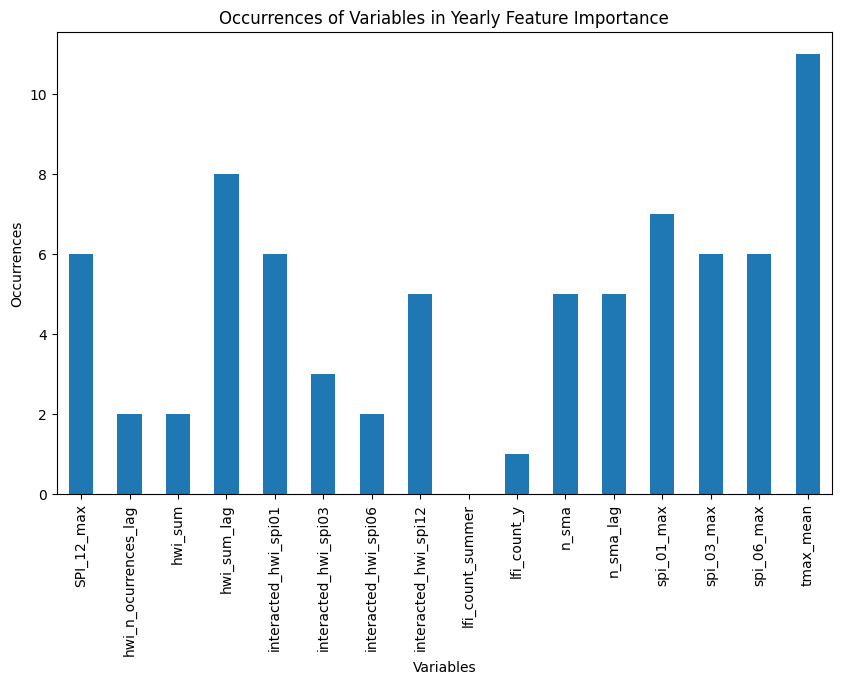

In [18]:
# Count the occurrence of each variable across all years
variable_occurrences = pd.Series(dtype=int, index=final_df.Feature.unique())
for year, importance_df in yearly_feature_nz_importance.items():
    variable_occurrences = variable_occurrences.add(importance_df['Feature'].value_counts(), fill_value=0)

# Plot histogram
plt.figure(figsize=(10, 6))
variable_occurrences.plot(kind='bar')
plt.title('Occurrences of Variables in Yearly Feature Importance')
plt.xlabel('Variables')
plt.ylabel('Occurrences')
plt.xticks(rotation=90)
# plt.show()
plt.savefig("Manuf_import_count_ALL.png")

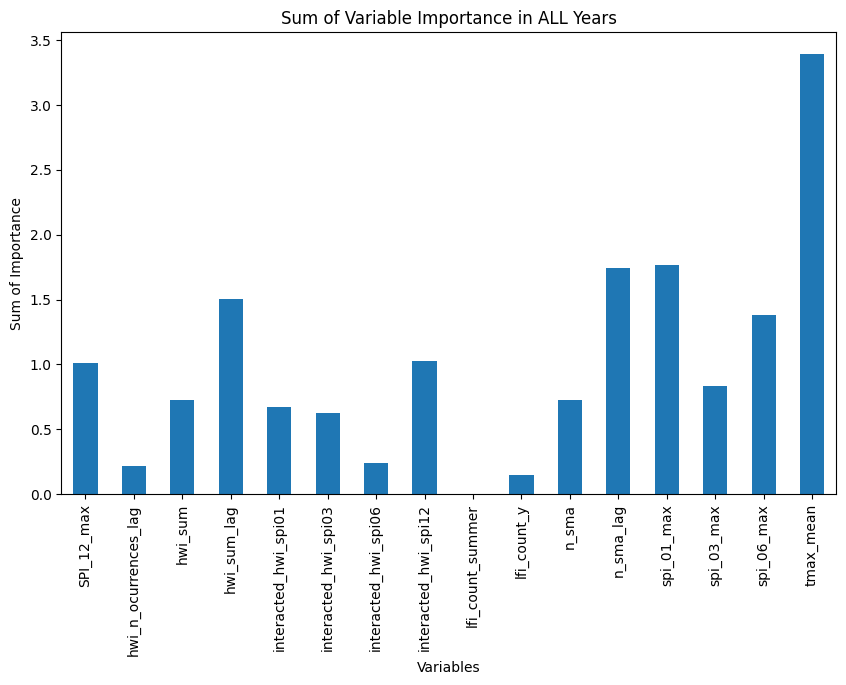

In [19]:
# Sum the importance of each variable in the crisis years
importance_sum = final_df.groupby('Feature')['Importance'].sum().reindex(variable_occurrences.index)

# Plot the sum of importance in crisis years
plt.figure(figsize=(10, 6))
importance_sum.plot(kind='bar')
plt.title('Sum of Variable Importance in ALL Years')
plt.xlabel('Variables')
plt.ylabel('Sum of Importance')
plt.xticks(rotation=90)
# plt.show()
plt.savefig("Manuf_import_sum_ALL.png")

## CRISIS YEARS 

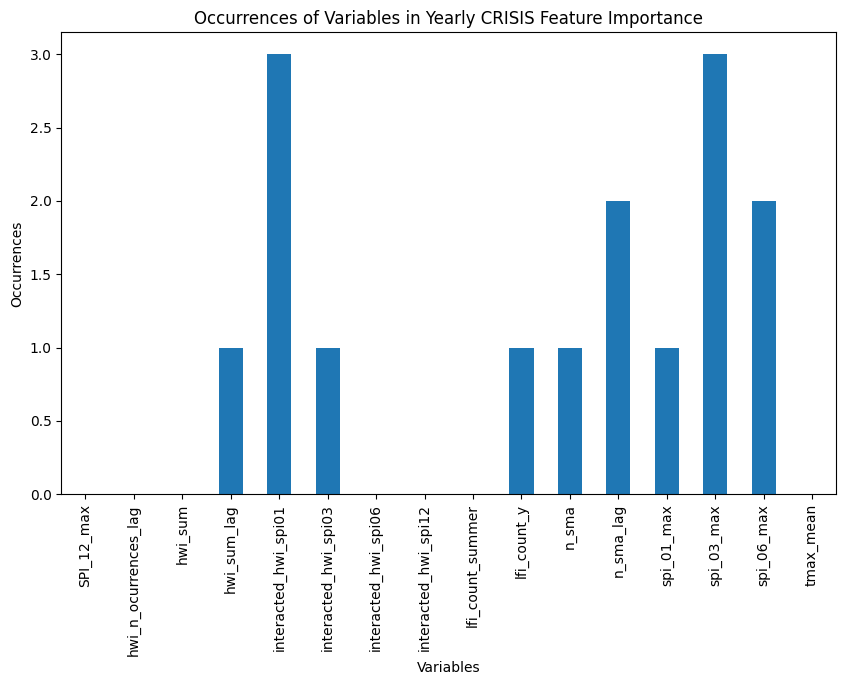

In [20]:
CRISIS_YEARS = [2003, 2015, 2018]

# Count the occurrence of each variable across all years
variable_occurrences = pd.Series(dtype=int, index=final_df.Feature.unique())
for year, importance_df in yearly_feature_nz_importance.items():
    if year in CRISIS_YEARS:
        variable_occurrences = variable_occurrences.add(importance_df['Feature'].value_counts(), fill_value=0)

# Plot histogram
plt.figure(figsize=(10, 6))
variable_occurrences.plot(kind='bar')
plt.title('Occurrences of Variables in Yearly CRISIS Feature Importance')
plt.xlabel('Variables')
plt.ylabel('Occurrences')
plt.xticks(rotation=90)
# plt.show()
plt.savefig("Manuf_import_counts_CRISIS.png")

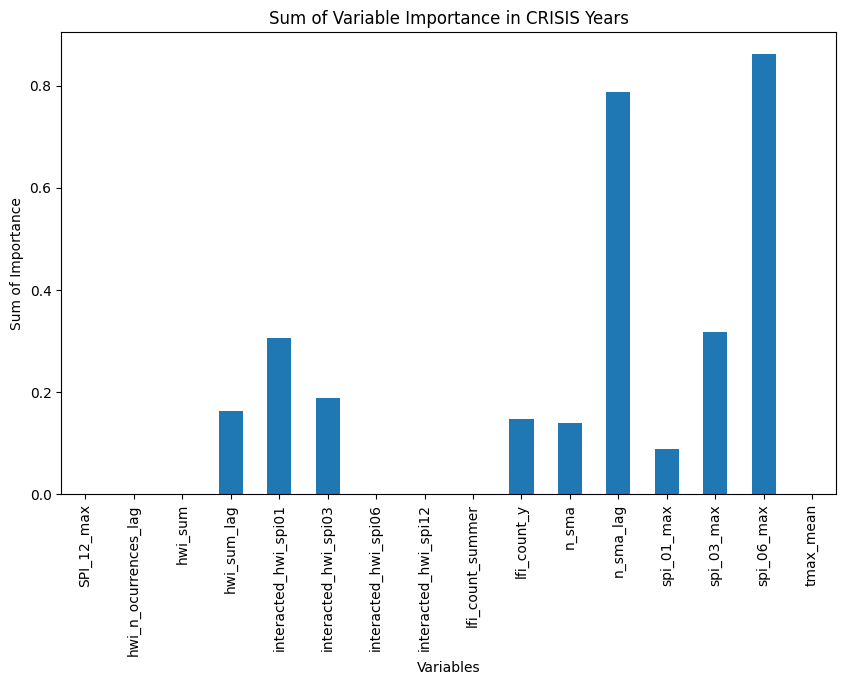

In [21]:
# Sum the importance of each variable in the crisis years
importance_sum = final_df[final_df['year'].isin(CRISIS_YEARS)].groupby('Feature')['Importance'].sum().reindex(variable_occurrences.index)

# Plot the sum of importance in crisis years
plt.figure(figsize=(10, 6))
importance_sum.plot(kind='bar')
plt.title('Sum of Variable Importance in CRISIS Years')
plt.xlabel('Variables')
plt.ylabel('Sum of Importance')
plt.xticks(rotation=90)
# plt.show()
plt.savefig("Manuf_import_sum_CRISIS.png")